## <font color='green'>MSEplots on PYPI: pip install MSEplots-pkg
----------
Wei-Ming Tsai, University of Miami, RSMAS<br>
wxt108@rsmas.miami.edu

- This Python package constructs a modernized and informative diagram for sounding data, providing static energies, entropies, CAPE/CIN, precipitable water, CRH ,etc. Differnet entrainment assumptions are optional for parcel buoyancy calculations.

- Four kinds of entrainment assumptions: (1) constant mixing, (2) deep inflow A, (3) deep inflow B and (4) dynamic mixing. See more details in [Sahany et al. (2012)](https://journals.ametsoc.org/doi/full/10.1175/JAS-D-11-0164.1)

- Global sounding data is available on the [Wyoming Uppper Air webpage](http://weather.uwyo.edu/upperair/sounding.html) where traditional Skew-T diagrams are displayed. Input sounding profiles of state variables are interploated into 200 levels with even intervals in the pressure coordinate for entrainment calculations.

Last update: 05/16/2019

### 1. import modules and sounding data

In [1]:
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime
from MSEplots import plots as mpt
from metpy.calc.thermo import *
from metpy.units import units
from scipy.interpolate import interp1d

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# reading data prociding vertical profiles of T, Td, pressure and height
date = datetime(2018, 8, 25, 0)
station = 'MFL'

df = WyomingUpperAir.request_data(date, station)
pp = df['pressure'].values #hPa
TT = df['temperature'].values  #C
Tdd = df['dewpoint'].values #C
ZZ = df['height'].values   #m

# linear interpoaltion into pressure levels
p = np.linspace(pp[0],pp[-1],200) # 200 pressure levels
# interpolated variables T, Td, Z
f = interp1d(pp,TT); T = f(p)
f = interp1d(pp,Tdd); Td = f(p)
f = interp1d(pp,ZZ); Z = f(p)

r = mixing_ratio( saturation_vapor_pressure(Td*units('degC')), p*units('hPa') ) 
q = specific_humidity_from_mixing_ratio(r).magnitude
rs = mixing_ratio( saturation_vapor_pressure(T*units('degC')), p*units('hPa') ) 
qs = specific_humidity_from_mixing_ratio(rs).magnitude

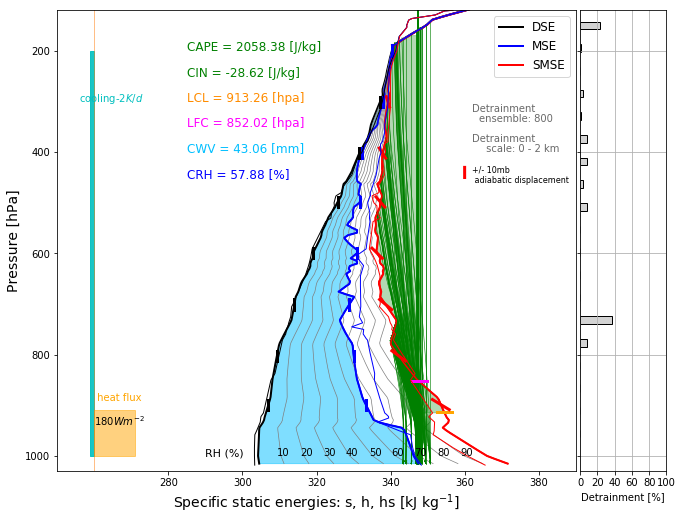

In [4]:
ax = mpt.msed_plots(p, T ,q , Z, h0_std=2000, ensemble_size=20, ent_rate=np.arange(0,2,0.05), entrain=True)
mpt.add_RCEREF(ax,cooling=-2,heatflux=180)
mpt.add_curves_Wyoming(ax,datetime(2013,8,26,0),'MFL',linewidth=1.0)

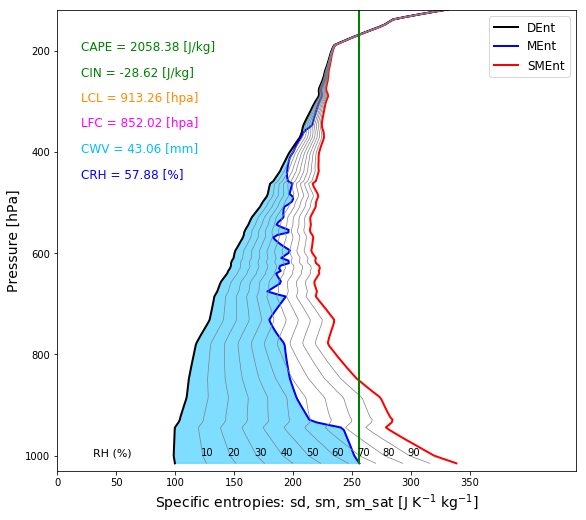

In [5]:
ax = mpt.entropy_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=False)

### 2. Applying entrainment methods to the current sounding

In [6]:
# calculate mixing coefficients for each method
s = mpt.MSE(T,Z,q*1e-9) #/1000*units.units('kJ/kg')
h = mpt.MSE(T,Z,q)      #/1000*units.units('kJ/kg')
hs = mpt.MSE(T,Z,qs)    #/1000*units.units('kJ/kg')

#(1) constant mixing coefficient 
X_c1 = mpt.entrain_const(p,c=1e-3)
hp_c1, qp_c1 = mpt.conserved_dmix(h,q,X_c1)

#(2) deep inflow mixing A
X_A = mpt.entrain_coeffA(Z,p,ce=0.4)
hp_mixA, qp_mixA = mpt.conserved_dmix(h,q,X_A)

#(3) deep inflow mixing B
X_B, m = mpt.entrain_coeffB(p)
hp_mixB, qp_mixB = mpt.conserved_dmix(h,q,X_B)

#(4) dynamic mixing 
X_dyn, omega_diag, B_diag, b = mpt.entrain_dyn(h,T,q,Z,p,Xmin=1e-3)
hp_mixdyn, qp_mixdyn = mpt.conserved_dmix(h,q,X_dyn)

MSE invert not converging


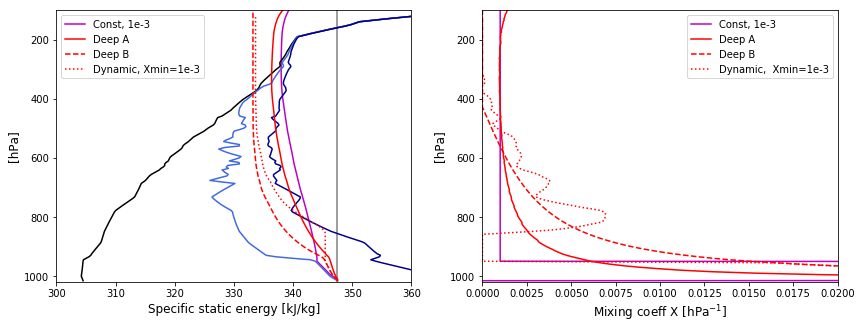

In [7]:
ax1, ax2 = mpt.entrainment_plot(hp_c1,X_c1,s,h,hs,p)

# add results of different assumptions
ax1.plot(hp_mixA/1000,p,'r')
ax1.plot(hp_mixB/1000,p,'--r')
ax1.plot(hp_mixdyn/1000,p,':r')
ax1.legend(['Const, 1e-3','Deep A','Deep B','Dynamic, Xmin=1e-3'])

# adding results of different assumptions
dp = -np.append(0,np.diff(p))
ax2.plot(X_A/dp,p,'r')
ax2.plot(X_B/dp,p,'--r')
ax2.plot(X_dyn/dp,p,':r')
ax2.legend(['Const, 1e-3','Deep A','Deep B','Dynamic,  Xmin=1e-3'])